# Interpolation loop

Run for 2 month period, loop over files pulling 7(?) days material, interpolate and calculate adjustemnts

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
from sklearn import ensemble


## Data preparation

### Grid

In [390]:
grid_gdf = gpd.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")
print(grid_gdf.crs)
grid_gdf = grid_gdf.set_crs(4326, allow_override=True)
print(grid_gdf.crs)

LOCAL_CS["Undefined Cartesian SRS with unknown unit",UNIT["unknown",0],AXIS["X",OTHER],AXIS["Y",OTHER]]
EPSG:4326


<Axes: >

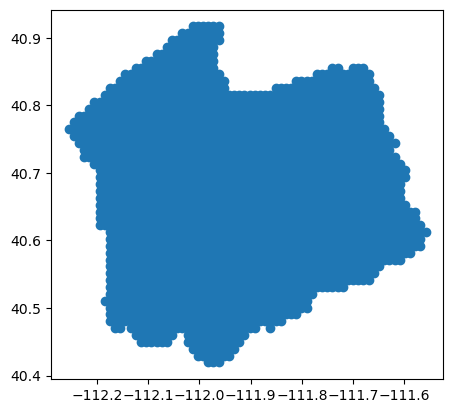

In [391]:
grid_gdf.plot()

<Axes: >

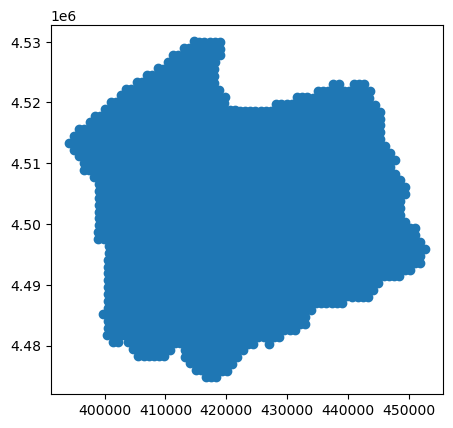

In [392]:
grid_gdf = grid_gdf.to_crs(32612)
grid_gdf.plot()

In [393]:
grid_crds = grid_gdf.get_coordinates()
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()
print(min_x, max_x, min_y, max_y)

394062.4609033931 452770.54888488085 4474740.877340379 4530011.489211138


In [394]:
## Updated to help estimate of basis functions
min_x = 393500
max_x = 453500
min_y = 4472000
max_y = 4532000
print(min_x, max_x, min_y, max_y)

393500 453500 4472000 4532000


In [395]:
print(np.round(max_x - min_x))
print(np.round(max_y - min_y))

60000
60000


In [396]:
grid_crds['normalized_east'] = (grid_crds['x']-min_x)/(max_x - min_x)
grid_crds['normalized_north'] = (grid_crds['y']-min_y)/(max_y-min_y)

## Load monitor data

In [397]:
aq_df = pd.read_csv("./data/loop_test/summer23_ozone_stationary.csv")
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement
0,2005,40.598056,-111.894167,Ozone,2023-06-01T00:00:00Z,2023-06-01,0S,0.044
1,2005,40.598056,-111.894167,Ozone,2023-06-01T01:00:00Z,2023-06-01,1H 0M 0S,0.034
2,2005,40.598056,-111.894167,Ozone,2023-06-01T02:00:00Z,2023-06-01,2H 0M 0S,0.030
3,2005,40.598056,-111.894167,Ozone,2023-06-01T03:00:00Z,2023-06-01,3H 0M 0S,0.031
4,2005,40.598056,-111.894167,Ozone,2023-06-01T04:00:00Z,2023-06-01,4H 0M 0S,0.023


In [398]:
aq_df.shape

(11592, 8)

In [399]:
aq_df['day_time'] = pd.to_datetime(aq_df['day_time']).dt.tz_localize(None)
# add the timezone:
aq_df['day_time'] = aq_df['day_time'] + pd.Timedelta(hours=7)

print(aq_df['day_time'][0:10])
print(aq_df['day_time'].dtype)

0   2023-06-01 07:00:00
1   2023-06-01 08:00:00
2   2023-06-01 09:00:00
3   2023-06-01 10:00:00
4   2023-06-01 11:00:00
5   2023-06-01 12:00:00
6   2023-06-01 13:00:00
7   2023-06-01 14:00:00
8   2023-06-01 15:00:00
9   2023-06-01 16:00:00
Name: day_time, dtype: datetime64[ns]
datetime64[ns]


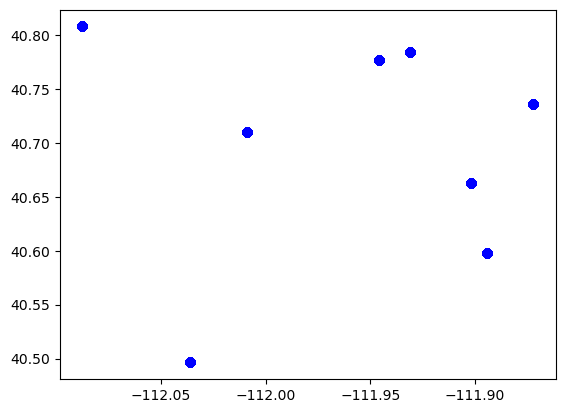

In [400]:
plt.plot(aq_df['longitude'], aq_df['latitude'], 'bo')

### Standardize coordinates

In [401]:
aq_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(aq_df.longitude, aq_df.latitude, crs="EPSG:4326"), data=aq_df
)
print(aq_gdf.crs)

EPSG:4326


In [402]:
aq_gdf = aq_gdf.to_crs(32612)
print(aq_gdf.crs)

EPSG:32612


In [403]:
aq_crds = aq_gdf.get_coordinates()
lon = aq_crds.x
lat = aq_crds.y
aq_df['normalized_east'] = (lon-min_x)/(max_x - min_x)
aq_df['normalized_north'] = (lat-min_y)/(max_y-min_y)
N = lon.shape[0]
print(N)

11592


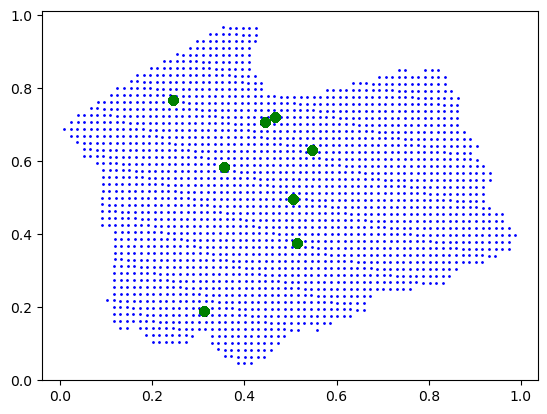

In [404]:
plt.plot(grid_crds['normalized_east'], grid_crds['normalized_north'], 'bo', markersize=1)
plt.plot(aq_df['normalized_east'], aq_df['normalized_north'], 'go')
plt.show()

### Standardize time

Note this needs to be run in a loop (by 7 day period?)

In [405]:
day_time = aq_df['day_time'].astype('int64') / 1e9 ## Time in nanoseconds

In [406]:
min_t = day_time.min()
max_t = day_time.max()
print(min_t, max_t)

1685602800.0 1690869600.0


In [407]:
aq_df['normalized_time'] = (day_time - min_t) / (max_t-min_t)
aq_df['normalized_time']

0        0.000000
1        0.000684
2        0.001367
3        0.002051
4        0.002734
           ...   
11587    0.997266
11588    0.997949
11589    0.998633
11590    0.999316
11591    1.000000
Name: normalized_time, Length: 11592, dtype: float64

## Load ebus data

In [408]:
ebus = pd.read_csv("./data/loop_test/ebus_2023_06-07.csv", header = [0,1],  
                 na_values = -9999.00)
ebus.shape

(177071, 23)

In [409]:
ebus

,Unnamed: 0_level_0,times,LAT,LON,ELV,ROW,COL,GSP,SP,TT,...,PM4,PM10,PRHI,O3,PMF,O3F,GPF,SPF,day_time,day
,1,2023-07-01 00:00:00,40.76355,-111.90943,1293.4,63,58,0,0,29.6,...,NA,NA,12,59.5,0,0,1,1,2023-07-01,2023-07-01
0,2,2023-07-01 00:00:00,40.70350,-111.97723,1293.9,51,45,0.0,0.0,29.5,...,NaN,NaN,NaN,57.3,0,0,0,1.0,2023-07-01,2023-07-01
1,3,2023-07-01 00:00:00,40.69294,-111.96915,1303.8,49,46,13.5,13.4,31.1,...,NaN,NaN,11.0,60.4,0,0,0,0.0,2023-07-01,2023-07-01
2,4,2023-07-01 00:00:00,40.69298,-111.96718,1301.2,49,47,1.3,1.0,31.1,...,NaN,NaN,11.0,57.8,0,0,0,0.0,2023-07-01,2023-07-01
3,5,2023-07-01 00:01:00,40.70347,-111.97723,1293.9,51,45,3.6,0.8,29.6,...,NaN,NaN,NaN,52.5,0,0,0,1.0,2023-07-01 00:01:00,2023-07-01
4,6,2023-07-01 00:01:00,40.69294,-111.97194,1303.3,49,46,11.6,12.5,31.1,...,NaN,NaN,11.0,61.0,0,0,0,0.0,2023-07-01 00:01:00,2023-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177066,177068,2023-06-30 23:58:00,40.69344,-111.96056,1297.0,49,48,0.0,0.0,31.0,...,NaN,NaN,11.0,56.0,0,0,0,1.0,2023-06-30 23:58:00,2023-06-30
177067,177069,2023-06-30 23:59:00,40.69312,-111.96054,1296.3,49,48,1.2,1.0,31.1,...,NaN,NaN,11.0,54.6,0,0,0,0.0,2023-06-30 23:59:00,2023-06-30
177068,177070,2023-06-30 23:59:00,40.70405,-111.97715,1293.2,51,45,0.0,0.0,29.4,...,NaN,NaN,NaN,57.8,0,0,0,1.0,2023-06-30 23:59:00,2023-06-30


In [410]:
ebus = pd.read_csv("./data/loop_test/ebus_2023_06-07.csv", header = [0,1],  
                 na_values = -9999.00)
ebus2_df = pd.DataFrame({
    'time': pd.to_datetime(ebus.iloc[:,1]),
    'lon': ebus.iloc[:,3],
    'lat': ebus.iloc[:,2]
    })
ebus2_df['val'] = ebus['O3'] / 1000
ebus2_df
ebus2_df.head()

,time,lon,lat,val
0,2023-07-01 00:00:00,-111.97723,40.70350,0.0573
1,2023-07-01 00:00:00,-111.96915,40.69294,0.0604
2,2023-07-01 00:00:00,-111.96718,40.69298,0.0578
3,2023-07-01 00:01:00,-111.97723,40.70347,0.0525
4,2023-07-01 00:01:00,-111.97194,40.69294,0.0610


In [411]:
ebus2_df.time

0        2023-07-01 00:00:00
1        2023-07-01 00:00:00
2        2023-07-01 00:00:00
3        2023-07-01 00:01:00
4        2023-07-01 00:01:00
                 ...        
177066   2023-06-30 23:58:00
177067   2023-06-30 23:59:00
177068   2023-06-30 23:59:00
177069   2023-06-30 23:59:00
177070   2023-06-30 23:59:00
Name: time, Length: 177071, dtype: datetime64[ns]

In [412]:
ebus2_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(ebus2_df.lon, ebus2_df.lat, crs="EPSG:4326"), data=ebus2_df
)
print(ebus2_gdf.crs)

ebus2_gdf = ebus2_gdf.to_crs(32612)
print(ebus2_gdf.crs)

ebus2_crds = ebus2_gdf.get_coordinates()
lon = ebus2_crds.x
lat = ebus2_crds.y
ebus2_df['normalized_east'] = (lon-min_x)/(max_x - min_x)
ebus2_df['normalized_north'] = (lat-min_y)/(max_y-min_y)


EPSG:4326
EPSG:32612


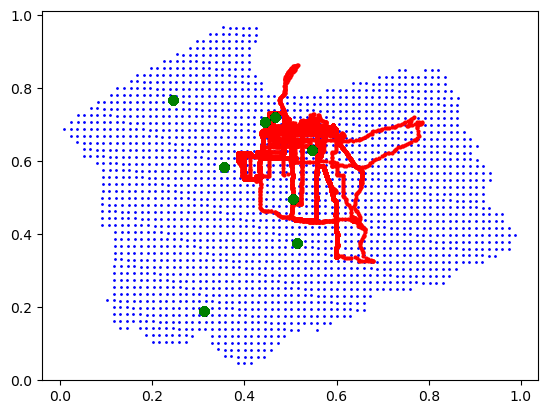

In [413]:
plt.plot(grid_crds['normalized_east'], grid_crds['normalized_north'], 'bo', markersize=1)
plt.plot(ebus2_df['normalized_east'], ebus2_df['normalized_north'], 'ro', markersize=2)
plt.plot(aq_df['normalized_east'], aq_df['normalized_north'], 'go')
plt.show()

## Basis functions

### Time

We need to define:
- Number of basis layers (3)
- Number of knots per layer
- S.D. for Gaussian function

Then make a ragged array holding the knots on the normalized scale.

Note that one of the previous examples has a very high number of temporal knots (~800) which is very computationally expensive

In [414]:
## Function to make knots in 1D space/time [0, 1]. Pass vector of number of knots in 1D
def make_knots_time(n):
    knots = [np.linspace(0,1,int(i)) for i in n]
    return(knots)

In [415]:
def get_basis_gaussian_1d(s, num_basis, knots, std_arr):
    N = len(s)
    phi = np.zeros((N, sum(num_basis)))
    K = 0
    for res in range(len(num_basis)):
        std = std_arr[res]
        for i in range(num_basis[res]):
            d = np.square(np.absolute(s-knots[res][i]))
            for j in range(len(d)):
                if d[j] >= 0 and d[j] <= 1:
                    phi[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
                else:
                    phi[j,i + K] = 0
        K = K + num_basis[res]
    return(phi)

In [416]:
## time basis 
## 14 day basis function (/2 for 7 day)
num_basis = [10,20,56]
std_arr = [0.3,0.15,0.05]

knots_1d_t = make_knots_time(num_basis)
knots_1d_t

[array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([0.        , 0.01818182, 0.03636364, 0.05454545, 0.07272727,
        0.09090909, 0.10909091, 0.12727273, 0.14545455, 0.16363636,
        0.18181818, 0.2       , 0.21818182, 0.23636364, 0.25454545,
        0.27272727, 0.29090909, 0.30909091, 0.32727273, 0.34545455,
        0.36363636, 0.38181818, 0.4       , 0.41818182, 0.43636364,
        0.45454545, 0.47272727, 0.49090909, 0.50909091, 0.52727273,
        0.54545455, 0.56363636, 0.58181818, 0.6       , 0.61818182,
        0.63636364, 0.65454545, 0.67272727, 0.69090909, 0.70909091,
        0.72727273, 0.74545455, 0.76363636, 

In [417]:
## Monitor bases
s = np.array(aq_df['normalized_time']).reshape(len(aq_df),1)
phi_t1 = get_basis_gaussian_1d(s, num_basis, knots_1d_t, std_arr)

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_84462/1313438311.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


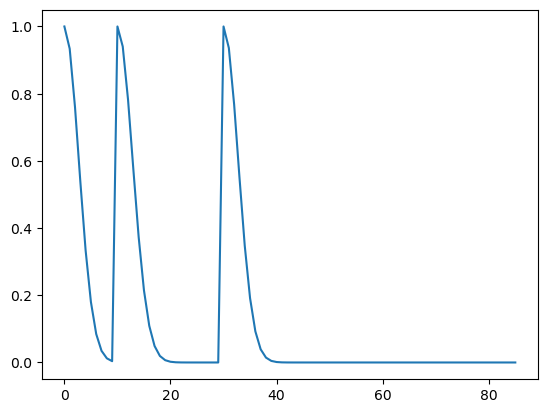

In [418]:
plt.plot(phi_t1[0,:])

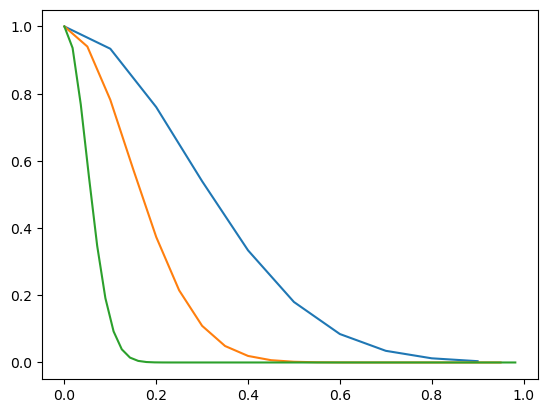

In [419]:
plt.plot(np.arange(0, 1, 1/num_basis[0]), phi_t1[0, 0:num_basis[0]])
plt.plot(np.arange(0, 1, 1/num_basis[1]), phi_t1[0, 10:30])
plt.plot(np.arange(0, 1, 1/num_basis[2]), phi_t1[0, 30:86])
plt.show()

### Space

In [420]:
## Function to make knots in 2D space [0, 1]. Pass vector of number of knots in 2D (i.e. res of 5, pass 25)
def make_knots_space(n):
    knots = [np.linspace(0,1,int(np.sqrt(i))) for i in n]
    return knots

In [421]:
def get_basis_wendland_2d(s, num_basis, knots_1d):
    ## Get weights from Wendland kernel
    N = len(s)
    K = 0
    phi = np.zeros((N, sum(num_basis)))
    for res in range(len(num_basis)):
        theta = 1/np.sqrt(num_basis[res])*2.5
        knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
        knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
        for i in range(num_basis[res]):
            d = np.linalg.norm(s-knots[i,:],axis=1)/theta
            for j in range(len(d)):
                if d[j] >= 0 and d[j] <= 1:
                    phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
                else:
                    phi[j,i + K] = 0
        K = K + num_basis[res]
    return(phi)

In [422]:
## Knots for spatial dimension (from STDK example)
num_basis = [5**2,9**2,11**2]
num_basis = [7**2,13**2,25**2] ## For 60km grid this is 10/5/2.5 resolution
knots_1d_s = make_knots_space(num_basis)
knots_1d_s

[array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        ]),
 array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
        0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
        0.83333333, 0.91666667, 1.        ]),
 array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
        0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
        0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
        0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
        0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])]

In [423]:
s = np.vstack((aq_df['normalized_east'],aq_df['normalized_north'])).T
N = s.shape[0]
phi_s1 = get_basis_wendland_2d(s, num_basis, knots_1d_s)

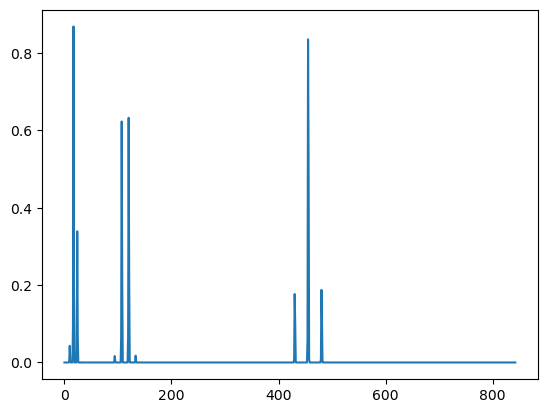

In [424]:
plt.plot(phi_s1[0,:])

In [425]:
print(len(np.arange(0, 1, 1/169)))
print(len(phi_s1[0, 49:218]))

169
169


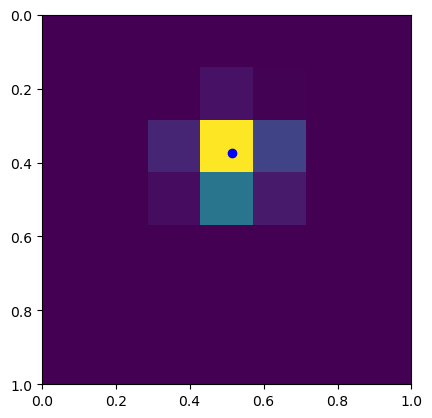

In [426]:
x = phi_s1[0,0:49]
x = x.reshape(7, 7)
plt.imshow(x, extent=[0, 1, 1, 0])
plt.plot(aq_df['normalized_east'].iloc[0], aq_df['normalized_north'].iloc[0], 'bo')
plt.show()

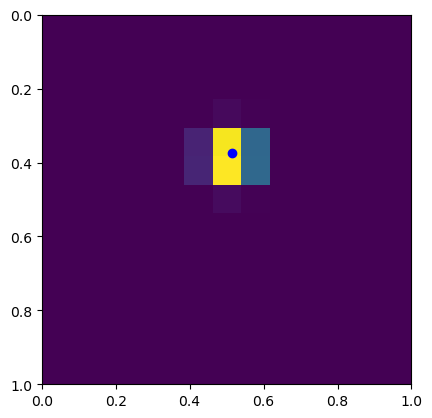

In [427]:
x = phi_s1[0,49:218]
x = x.reshape(13, 13)
plt.imshow(x, extent=[0, 1, 1, 0])
plt.plot(aq_df['normalized_east'].iloc[0], aq_df['normalized_north'].iloc[0], 'bo')
plt.show()

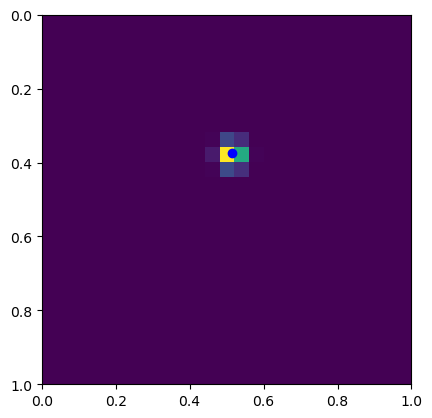

In [428]:
x = phi_s1[0,218:843]
x = x.reshape(25, 25)
plt.imshow(x, extent=[0, 1, 1, 0])
plt.plot(aq_df['normalized_east'].iloc[0], aq_df['normalized_north'].iloc[0], 'bo')
plt.show()

#### EBus data

In [429]:
s = np.vstack((ebus2_df['normalized_east'],ebus2_df['normalized_north'])).T
N = s.shape[0]

In [430]:
phi_s2 = get_basis_wendland_2d(s, num_basis, knots_1d_s)

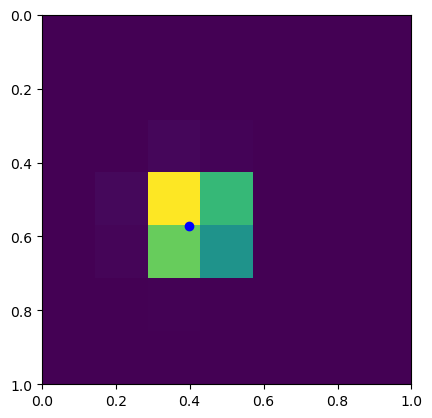

In [431]:
x = phi_s2[0,0:49]
x = x.reshape(7, 7)
plt.imshow(x, extent=[0, 1, 1, 0])
plt.plot(ebus2_df['normalized_east'].iloc[0], ebus2_df['normalized_north'].iloc[0], 'bo')
plt.show()

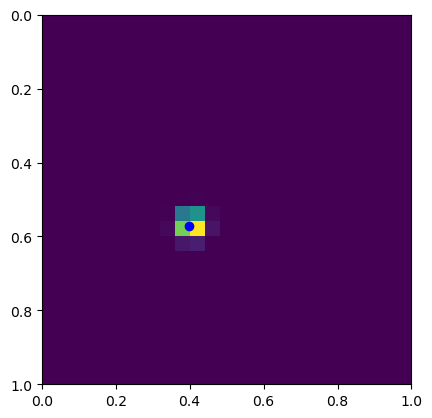

In [432]:
x = phi_s2[0,218:843]
x = x.reshape(25, 25)
plt.imshow(x, extent=[0, 1, 1, 0])
plt.plot(ebus2_df['normalized_east'].iloc[0], ebus2_df['normalized_north'].iloc[0], 'bo')
plt.show()

### Combine basis functions

In [433]:
phi_1 = np.hstack((phi_t1,phi_s1))

Remove all columns with no non-zero values

In [434]:
idx_zero = np.array([], dtype=int)
for i in range(phi_1.shape[1]):
    if sum(phi_1[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_1_reduce = np.delete(phi_1,idx_zero,1)
print(phi_1.shape)
print(phi_1_reduce.shape)

(11592, 929)
(11592, 296)


## Run example week

In [435]:
target_date = pd.to_datetime("2023-07-07")
target_date = pd.to_datetime("2023-07-31")
target_date = pd.to_datetime("2023-06-07")

start_date = target_date - pd.to_timedelta(7, unit='d')

In [436]:
print(target_date)
print(start_date)

2023-06-07 00:00:00
2023-05-31 00:00:00


### Get training data

In [437]:
start_date_train = target_date - pd.to_timedelta(7, unit='d')
stop_date_train = target_date + pd.to_timedelta(1, unit='d')
aq_df_sub = aq_df[(aq_df['day_time'] >= start_date_train) & (aq_df['day_time'] < stop_date_train)].copy()
aq_df_sub.day_time
# aq_df_sub = aq_df_sub.copy(deep=True)

0       2023-06-01 07:00:00
1       2023-06-01 08:00:00
2       2023-06-01 09:00:00
3       2023-06-01 10:00:00
4       2023-06-01 11:00:00
                ...        
10292   2023-06-07 19:00:00
10293   2023-06-07 20:00:00
10294   2023-06-07 21:00:00
10295   2023-06-07 22:00:00
10296   2023-06-07 23:00:00
Name: day_time, Length: 1280, dtype: datetime64[ns]

In [438]:
day_time = aq_df_sub['day_time'].astype('int64') / 1e9 ## Time in nanoseconds
min_t = day_time.min()
max_t = day_time.max()
aq_df_sub['normalized_time'] = (day_time - min_t) / (max_t-min_t)
# aq_df_sub['normalized_time']

In [439]:
aq_df_sub['normalized_time']

0        0.00000
1        0.00625
2        0.01250
3        0.01875
4        0.02500
          ...   
10292    0.97500
10293    0.98125
10294    0.98750
10295    0.99375
10296    1.00000
Name: normalized_time, Length: 1280, dtype: float64

In [440]:
## time basis 
## 14 day basis function (/2 for 7 day)
num_basis_t = [10,20,56]
std_arr = [0.3,0.15,0.05]

knots_1d_t = make_knots_time(num_basis_t)
knots_1d_t

s = np.array(aq_df_sub['normalized_time']).reshape(len(aq_df_sub),1)
phi_t1 = get_basis_gaussian_1d(s, num_basis_t, knots_1d_t, std_arr)
phi_t1.shape

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_84462/1313438311.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


(1280, 86)

In [441]:
phi_t1.shape

(1280, 86)

In [442]:
## Knots for spatial dimension (from STDK example)
num_basis_s = [5**2,9**2,11**2]
num_basis_s = [7**2,13**2,25**2] ## For 60km grid this is 10/5/2.5 resolution
knots_1d_s = make_knots_space(num_basis_s)
knots_1d_s

s = np.vstack((aq_df_sub['normalized_east'],aq_df_sub['normalized_north'])).T
phi_s1 = get_basis_wendland_2d(s, num_basis_s, knots_1d_s)
s.shape

(1280, 2)

In [443]:
phi_1 = np.hstack((phi_t1,phi_s1))
idx_zero = np.array([], dtype=int)
for i in range(phi_1.shape[1]):
    if sum(phi_1[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_1_reduce = np.delete(phi_1,idx_zero,1)
print(phi_1.shape)
print(phi_1_reduce.shape)

(1280, 929)
(1280, 296)


In [444]:
aq_df_sub.columns

Index(['site.num', 'latitude', 'longitude', 'parameter.name', 'day_time',
       'date', 'hour', 'sample.measurement', 'normalized_east',
       'normalized_north', 'normalized_time'],
      dtype='object')

In [445]:
X_train = phi_1_reduce
y_train = aq_df_sub['sample.measurement'].values

In [446]:
aq_rf = ensemble.RandomForestRegressor()
aq_rf.fit(X_train, y_train)

RandomForestRegressor()

In [447]:
y_train_pred = aq_rf.predict(X_train)

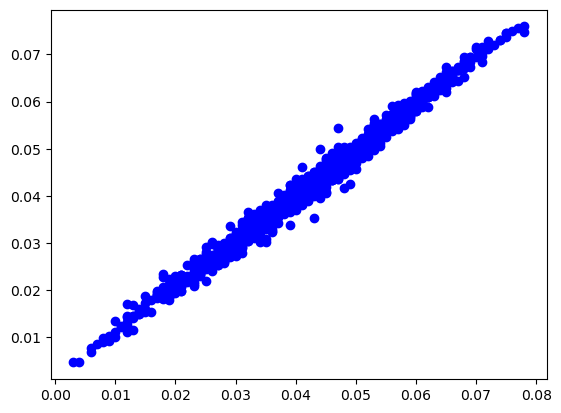

In [448]:
plt.plot(y_train, y_train_pred, 'bo')

### Prediction data

In [449]:
start_date_pred = target_date - pd.to_timedelta(1, unit='d')
stop_date_pred = target_date + pd.to_timedelta(1, unit='d')
print(target_date)
print(start_date_pred)
ebus2_df_sub = ebus2_df[(ebus2_df['time'] >= target_date) & (ebus2_df['time'] < stop_date_pred)]
ebus2_df_sub.time

2023-06-07 00:00:00
2023-06-06 00:00:00


96566   2023-06-07 00:00:00
96567   2023-06-07 00:00:00
96568   2023-06-07 00:00:00
96569   2023-06-07 00:00:00
96570   2023-06-07 00:00:00
                ...        
99835   2023-06-07 23:59:00
99836   2023-06-07 23:59:00
99837   2023-06-07 23:59:00
99838   2023-06-07 23:59:00
99839   2023-06-07 23:59:00
Name: time, Length: 3274, dtype: datetime64[ns]

In [450]:
day_time = ebus2_df_sub['time'].astype('int64') / 1e9 ## Time in nanoseconds
ebus2_df_sub['normalized_time'] = (day_time - min_t) / (max_t-min_t)
ebus2_df_sub['normalized_time']

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_84462/153948649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebus2_df_sub['normalized_time'] = (day_time - min_t) / (max_t-min_t)


96566    0.856250
96567    0.856250
96568    0.856250
96569    0.856250
96570    0.856250
           ...   
99835    1.006146
99836    1.006146
99837    1.006146
99838    1.006146
99839    1.006146
Name: normalized_time, Length: 3274, dtype: float64

In [451]:
s = np.array(ebus2_df_sub['normalized_time']).reshape(len(ebus2_df_sub),1)
s.shape

(3274, 1)

In [452]:
s = np.array(ebus2_df_sub['normalized_time']).reshape(len(ebus2_df_sub),1)
phi_t2 = get_basis_gaussian_1d(s, num_basis_t, knots_1d_t, std_arr)
phi_t2.shape

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_84462/1313438311.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


(3274, 86)

In [453]:
s = np.vstack((ebus2_df_sub['normalized_east'],ebus2_df_sub['normalized_north'])).T
phi_s2 = get_basis_wendland_2d(s, num_basis_s, knots_1d_s)
phi_s2.shape

(3274, 843)

In [454]:
phi_2 = np.hstack((phi_t2,phi_s2))
phi_2_reduce = np.delete(phi_2,idx_zero,1)
print(phi_2.shape)
print(phi_2_reduce.shape)

(3274, 929)
(3274, 296)


In [455]:
ebus2_df_sub.val

96566    0.0435
96567    0.0376
96568    0.0431
96569    0.0431
96570    0.0405
          ...  
99835    0.0602
99836    0.0477
99837    0.0483
99838    0.0520
99839    0.0526
Name: val, Length: 3274, dtype: float64

In [456]:
X_pred = phi_2_reduce
y_pred = ebus2_df_sub.val.values

In [457]:
y_pred_pred = aq_rf.predict(X_pred)

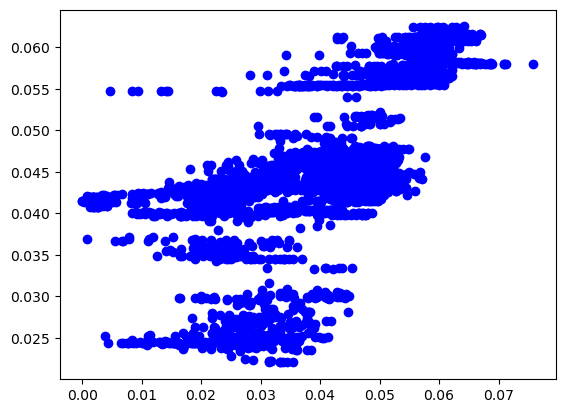

In [458]:
plt.plot(y_pred, y_pred_pred, 'bo')

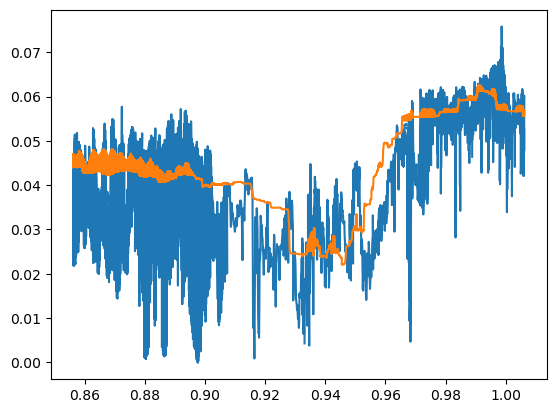

In [459]:
#plt.plot(aq_df_sub.normalized_time, y_train, 'bo', markersize = 0.5)
plt.plot(ebus2_df_sub.normalized_time, y_pred)
plt.plot(ebus2_df_sub.normalized_time, y_pred_pred)
plt.show()

## Mini loop example

In [460]:
all_days = aq_df.date.unique()
all_days = all_days[6:]
for i in all_days:
    print(i)
    target_date = pd.to_datetime(i)
    start_date = target_date - pd.to_timedelta(7, unit='d')
    #aq_df_sub = aq_df[(aq_df['day_time'] >= start_date) & (aq_df['day_time'] <= target_date)]
    #print(aq_df_sub.shape)

2023-06-07
2023-06-08
2023-06-09
2023-06-10
2023-06-11
2023-06-12
2023-06-13
2023-06-14
2023-06-15
2023-06-16
2023-06-17
2023-06-18
2023-06-19
2023-06-20
2023-06-21
2023-06-22
2023-06-23
2023-06-24
2023-06-25
2023-06-26
2023-06-27
2023-06-28
2023-06-29
2023-06-30
2023-07-01
2023-07-02
2023-07-03
2023-07-04
2023-07-05
2023-07-06
2023-07-07
2023-07-08
2023-07-09
2023-07-10
2023-07-11
2023-07-12
2023-07-13
2023-07-14
2023-07-15
2023-07-16
2023-07-17
2023-07-18
2023-07-19
2023-07-20
2023-07-21
2023-07-22
2023-07-23
2023-07-24
2023-07-25
2023-07-26
2023-07-27
2023-07-28
2023-07-29
2023-07-30
2023-07-31


In [461]:
start_date_pred = target_date - pd.to_timedelta(1, unit='d')
stop_date_pred = target_date + pd.to_timedelta(1, unit='d')
print(target_date)
print(start_date_pred)
ebus2_df_sub = ebus2_df[(ebus2_df['time'] >= target_date) & (ebus2_df['time'] < stop_date_pred)]
ebus2_df_sub.time

2023-07-31 00:00:00
2023-07-30 00:00:00


77421   2023-07-31 11:24:00
77422   2023-07-31 11:25:00
77423   2023-07-31 11:26:00
77424   2023-07-31 11:27:00
77425   2023-07-31 11:28:00
                ...        
79190   2023-07-31 23:55:00
79191   2023-07-31 23:56:00
79192   2023-07-31 23:57:00
79193   2023-07-31 23:58:00
79194   2023-07-31 23:59:00
Name: time, Length: 1774, dtype: datetime64[ns]

In [462]:
start_date_train = target_date - pd.to_timedelta(7, unit='d')
stop_date_train = target_date + pd.to_timedelta(1, unit='d')
print(target_date)
print(start_date_train)
aq_df_sub = aq_df[(aq_df['day_time'] >= start_date_train) & (aq_df['day_time'] < stop_date_train)]
aq_df_sub.day_time


2023-07-31 00:00:00
2023-07-24 00:00:00


1256    2023-07-24 00:00:00
1257    2023-07-24 01:00:00
1258    2023-07-24 02:00:00
1259    2023-07-24 03:00:00
1260    2023-07-24 04:00:00
                ...        
11580   2023-07-31 19:00:00
11581   2023-07-31 20:00:00
11582   2023-07-31 21:00:00
11583   2023-07-31 22:00:00
11584   2023-07-31 23:00:00
Name: day_time, Length: 1496, dtype: datetime64[ns]

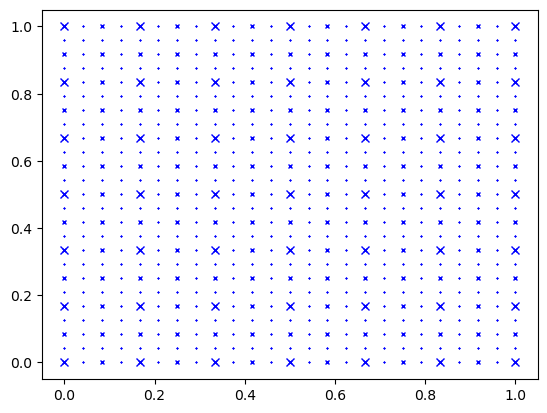

In [480]:
from functools import reduce
def expand_grid(*arrs):
    ncols = len(arrs)
    nrows = reduce(lambda x, y: x * y, map(len, arrs), 1)
    
    return np.array(np.meshgrid(*arrs)).reshape(ncols, nrows).T

x = expand_grid(knots_1d_s[0], knots_1d_s[0])
plt.plot(x[:,0], x[:,1], 'bx', markersize = 6)
x = expand_grid(knots_1d_s[1], knots_1d_s[1])
plt.plot(x[:,0], x[:,1], 'bx', markersize = 3)
x = expand_grid(knots_1d_s[2], knots_1d_s[2])
plt.plot(x[:,0], x[:,1], 'bx', markersize = 1)